In [1]:
# Load dependencies/packages
import numpy as np # for array operations
import pandas as pd # for neat tables, database-like grouping/summary tables & csv_read
import matplotlib.pyplot as plt # for the occasional plot
import seaborn as sns # for the occasional plot

from sklearn.model_selection import train_test_split # train / test split method

# for variable selection investigation, use correlation from pandas and stepwise linear regression
import statsmodels.api as sm # to help create Stepwise AIC Linear Regression
import random # for random selection of starting variables/features/predictors

### Classification Model Architectures ###
# 'previous' baseline methods
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
# (1) LDA with 'eigenvalue decomposition' solver, parameter to tune: 'shrinkage'
from sklearn.linear_model import LogisticRegression 
# (2) Logistic Regression with ElasticNet penalty, parameter to tune: 'L1 ratio (Lasso) vs. L2 ratio (Ridge)'
from sklearn.neighbors import KNeighborsClassifier # (3) KNN, parameter to tune: 'k neighbors'
from sklearn import tree 
# (4) Classification Tree (CART) split by 'gini', parameter to tune: ... 
# ... 'max depth' i.e. extent of how much the tree is grown before pruning

# 'new' ensemble methods
from sklearn.ensemble import RandomForestClassifier 
# (5) Random Forest (classification) split by 'gini', parameter to tune: ... 
# ... 'max depth' i.e. extent of how much the are individual trees grown AND 'n_estimators'
from sklearn.ensemble import AdaBoostClassifier 
# (6) Boosting (classification), parameter to tune: 'learning rate' AND 'n_estimators'
 
# PCA scaling, transformation
from sklearn.pipeline import make_pipeline # the create a pipeline of transforms necessary to undertake PCA Regression
from sklearn.preprocessing import StandardScaler # first, scale all data as required for PCA
from sklearn.decomposition import PCA # second, perform PCA and take k principal directions of the new linear transformation of X
# then finally use KNN

# Ignore convergence warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)

In [2]:
# Method to append to dict
def add_to_dict(dict_, key, value):
    if key not in dict_:
        dict_[key] = []
    dict_[key].append(value)
    
# alternatively, I could have used *from collections import defaultdict*

In [3]:
# Load Data, Create Binary Var 'mpg01'

### load Cleaned Data ###
# Originally, 398 rows/data points and 9 car attributes/features. 
# Attribute/feature description: 
# 1. mpg: continuous (miles per gallon i.e. fuel efficiency)
# 2. cylinders: multi-valued discrete  
# 3. displacement: continuous (engine size, as volume)
# (hard to determine, the ranges are too small to be car length, so it likely some chassis track/wheelbase measurement)
# 4. horsepower: continuous
# 5. weight: continuous (lbs)
# 6. acceleration: continuous (presumably 0-100 mph or something like this, the higher it is, the slower the car is)
# 7. model year: multi-valued discrete (years are YY, the dataset is from 1993, so YYYY notation is 19YY)
# 8. origin: multi-valued discrete 
# from investigation of car names, this is actually categorical 1 = US, 2 = Europe, 3 = Japan (this is before SK cars)
# 9. car name: string (unique for each instance)

# But, 6 rows/data pointshave values missing...
# ... NO IMPUTATION (estimation of missing attribute/feature values using the rest of the data set) as directed.
# ... Instead, these 6 rows/data points are DELETED.

# Furthermore, 1 attribute/feature is 'car name' and is REMOVED as it is non-numerical / cannot be categorized in a useful way.

auto_data = pd.read_csv('data/auto.csv') # Load cleaned data

### Create Binary Variable 'mpg01' ###
print(auto_data['mpg'].describe()) # check summary of 'mpg'
mpg_median = auto_data['mpg'].median() # mpg_median = 22.75
# if mpg >= mpg_median, then 1, otherwise 0 . int conversion required from true / false to 1 / 0.
auto_data['mpg01'] = (auto_data['mpg'] >= mpg_median).astype(int) 

# 'mpg01' (basically) represents:
# if 1 -> the car is average/above average (in terms of the scope of cars in the data set) in fuel efficiency, 
# if 0 -> the car is below average (in terms of the scope of cars in the data set) in fuel efficiency

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64


In [4]:
# Data Exploration
auto_data # Now 392 rows x 9 cols. 'mpg01' is the response/label, cols 1-7 are the predictors 'cylinders'~'origin'

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
0,18.0,8,307.0,130,3504,12.0,70,1,0
1,15.0,8,350.0,165,3693,11.5,70,1,0
2,18.0,8,318.0,150,3436,11.0,70,1,0
3,16.0,8,304.0,150,3433,12.0,70,1,0
4,17.0,8,302.0,140,3449,10.5,70,1,0
...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,1
388,44.0,4,97.0,52,2130,24.6,82,2,1
389,32.0,4,135.0,84,2295,11.6,82,1,1
390,28.0,4,120.0,79,2625,18.6,82,1,1


In [5]:
auto_data.iloc[:,1:7].describe() # don't numerically summarize 'mpg' or the categorical or binary values, there's no value 
# of note, the cars are from 1970 to 1982

,cylinders,displacement,horsepower,weight,acceleration,year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


In [6]:
auto_data_corr = auto_data.iloc[:,1:].corr() # ignore 'mpg'
auto_data_corr['mpg01']

cylinders      -0.759194
displacement   -0.753477
horsepower     -0.667053
weight         -0.757757
acceleration    0.346822
year            0.429904
origin          0.513698
mpg01           1.000000
Name: mpg01, dtype: float64

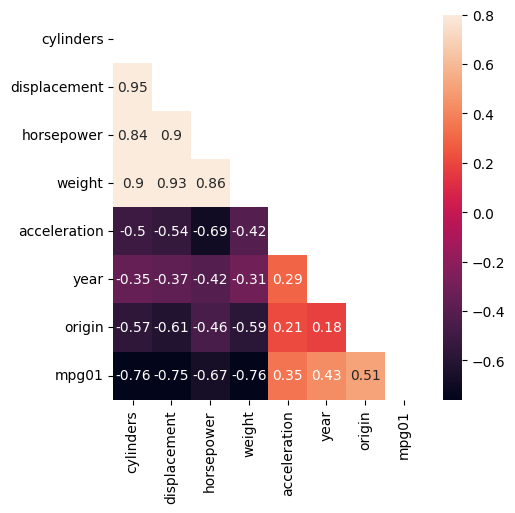

In [7]:
mask = np.triu(np.ones_like(auto_data_corr)) # add a mask
plt.subplots(figsize=(5, 5))
sns.heatmap(auto_data_corr, vmax=0.8, annot=True, mask=mask)
plt.show()  

<AxesSubplot:xlabel='origin', ylabel='mpg'>

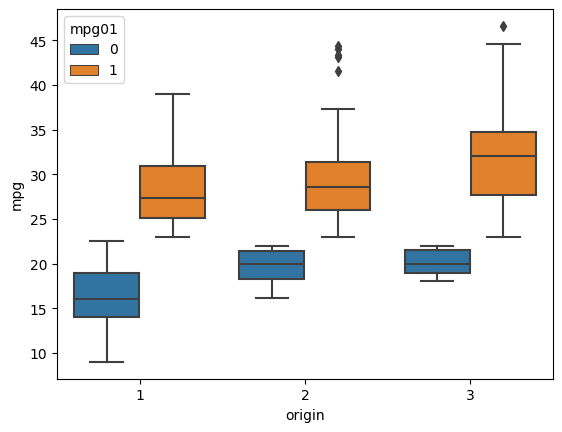

In [8]:
### Boxplots split by origin 1 US, 2 Europe, 3 Japan ###
sns.boxplot(data=auto_data, x="origin", y="mpg", hue="mpg01")
# origin, despite being categorical, holds value as the highest positively-correlated predictor variable.
# It demonstrates that US vehicles have lower fuel efficiency, then European cars, ... 
# ... then Japanese cars have higher fuel efficiency.
# This is somewhat of a stereotype, but the data reflects this. 
# This occurrence is typically explained economic and resource-availability.
# Firstly, the US is a oil-producing nation, therefore the economic pressures for fuel efficiency are much lower than in Japan.
# Japan historically was regarded as natural resource and energy poor, so there are economic pressures to reduce imports of oil
# and push for fuel efficiency. Whereas, in the US, with the availability of domestic oil, there are less pressures ...
# ... to develop higher levels of fuel efficiency. When also throwing in urban sprawl (population density),
# ... longer driving distances (intra and intercity) and lobbying by the domestic oil companies in the US, ... 
# it can become clear why the automotive industries in both nations evolved as they did. 
# There are plenty of retrospective papers on US vs Japan car manufacturing, should you wish to learn more.
# Without dragging on, we find that, stereotypically, European cars fall in-between the US and Japan cars.

<AxesSubplot:xlabel='origin', ylabel='displacement'>

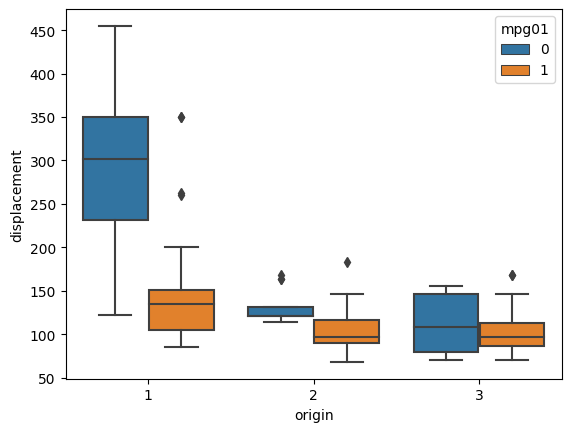

In [9]:
sns.boxplot(data=auto_data, x="origin", y="displacement", hue="mpg01")
# smaller engines, have higher fuel efficiency
# Again we find that European and Japanese cars have smaller engines than US cars.
# This is likely due to the great socio-economic influences mentioned above. 
# We also find bigger variability in engine size in the US.
# In saying that, we find that the vehicles with above average fuel efficiency tend to have a narrower range of engine size,
# compared to those with below average fuel efficiency. This likely due to the fact that a vast majority of the ...
# ... fuel efficient cars are all 4 cylinder vehicles and thus have a fairly narrow range of engine sizes.
# We are working on the idea that 'engines aren't bigger or heavier than they need to be'.

<AxesSubplot:xlabel='origin', ylabel='cylinders'>

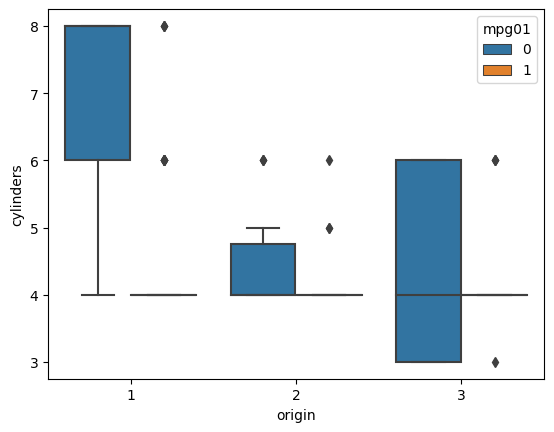

In [10]:
sns.boxplot(data=auto_data, x="origin", y="cylinders", hue="mpg01") 
# non-linear relationship because of below 4 cylinders generally being the floor value
# Generally-speaking, 4 cylinder or less vehicles have good fuel efficiency, there are some outliers in each 
# origin region (some 5, 6 or 8 cylinder cars). Also, stereotypically, we find that V8's are usually only US cars.
# We also find that European cars are mostly 4 to 5 cylinders only. Whereas Japanese cars will be 3 to 6 (V6) cylinders.

<AxesSubplot:xlabel='origin', ylabel='horsepower'>

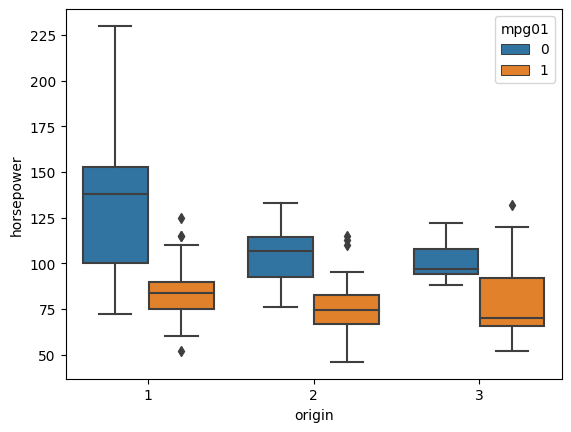

In [11]:
sns.boxplot(data=auto_data, x="origin", y="horsepower", hue="mpg01") # the higher the horsepower, the lower the fuel efficiency

<AxesSubplot:xlabel='origin', ylabel='weight'>

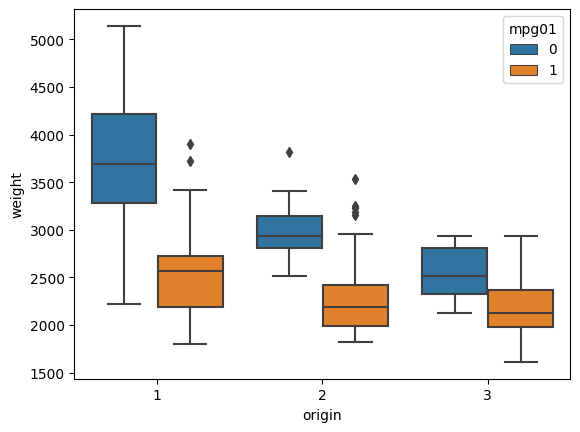

In [12]:
sns.boxplot(data=auto_data, x="origin", y="weight", hue="mpg01") # the higher the weight (lbs), the lower the fuel efficiency

<AxesSubplot:xlabel='origin', ylabel='acceleration'>

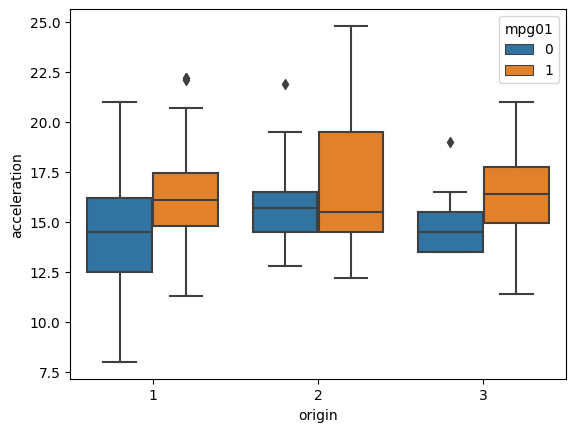

In [13]:
sns.boxplot(data=auto_data, x="origin", y="acceleration", hue="mpg01") 
# the longer the vehicle takes to accelerate (0-100 mph) i.e. the slower it accelerates, the higher the fuel efficiency

<AxesSubplot:xlabel='origin', ylabel='year'>

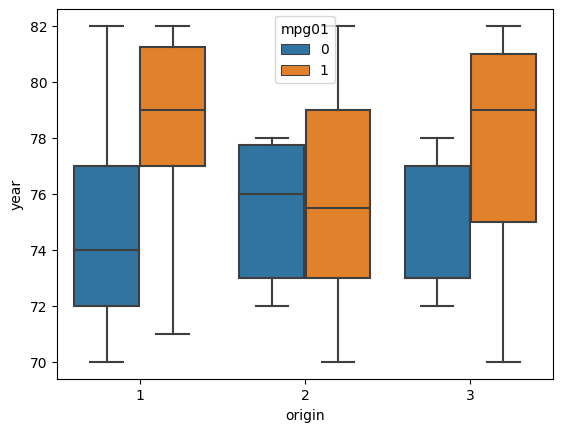

In [14]:
sns.boxplot(data=auto_data, x="origin", y="year", hue="mpg01") # the newer the car is, the higher the fuel efficiency

In [15]:
pred_var_names = list(auto_data.columns)
pred_var_names = pred_var_names[1:8]

In [16]:
# Linear regression with variables (stepwise) selected using AIC
def stepw_reg_mod(n_test, train_data, test_data, k_names, label):
    
    k_start_vars = 0; 
    current_vars = random.sample(k_names, k_start_vars) # this works with k=0

    # Initialize
    # OLS(Y,X + C'), Y-label is first, X-data is last. Need to assign a column of 1's to allow for intercept
    current_stepw_reg = sm.OLS(train_data[label], train_data[current_vars].assign(intercept=1)).fit() 
    current_aic = current_stepw_reg.aic

    step = 0
    max_steps = 20

    #best_forward_vars = current_vars[:]

    while step < max_steps:
        print('current vars:', current_vars)
        print('current AIC:', current_aic)

        ### Forward Step, try adding vars one at a time that improve AIC ###
        print('--- forward step', step, '---')
        best_forward_aic = 10000000 # initialize a dummy var for inner loop of forward step

        # 1. Get the list of potential vars to add
        potential_vars = k_names[:]
        for i in current_vars:
            potential_vars.remove(i) # get the full list and remove those in the model

        # 2. For each potential var, create a model and measure its AIC
        for var in potential_vars:
            forward_vars = current_vars[:]
            forward_vars.append(var)
            forward_stepw_reg = sm.OLS(train_data[label], train_data[forward_vars].assign(intercept=1)).fit()
            forward_aic = forward_stepw_reg.aic

            # 3. Store the potential var with the best AIC performance, and assoc. model, AIC and all model vars
            if forward_aic <= best_forward_aic:
                best_forward_var_to_add = var
                best_forward_vars = forward_vars[:]
                best_forward_aic = forward_aic
                best_forward_stepw_reg = forward_stepw_reg

        print('new var to add:', best_forward_var_to_add)
        print('new vars (forward):', best_forward_vars)
        print('new AIC (forward):', best_forward_aic)
        print('----------------------')

        ### Backwards Step ###
        # 1. Delete the var with the highest p-value > 0.05 signif level, from the current model
        # 2. Rebuild the model with the var deleted

        print('--- backward step', step, '---')
        backward_aic = 10000000 # initialize a dummy var for inner loop of backward step

        current_pvalues = current_stepw_reg.pvalues[:-1] # remove intercept from p signif test
        print('current p values:')
        print(current_pvalues)
        
        if np.max(current_pvalues) > 0.05:

            current_highest_p_var = current_pvalues.index[np.argmax(current_pvalues)]

            print('current var to remove:', current_highest_p_var)
            backward_vars = current_vars[:] # copy current_vars list because remove affects the original list due to pointers
            backward_vars.remove(current_highest_p_var)
            print('new vars (backward):', backward_vars)
            backward_stepw_reg = sm.OLS(train_data[label], train_data[backward_vars].assign(intercept=1)).fit()
            print(backward_stepw_reg.pvalues[:-1])
            backward_aic = backward_stepw_reg.aic
            print('new AIC (backward):', backward_aic)
            print("-----------------------")

        ### Model Selection for Step ###    
        if best_forward_aic < current_aic and best_forward_aic < backward_aic:
            print('****chose forward step****')
            print('')
            current_vars = best_forward_vars[:] # copy current_var list because remove affects the original list due to pointers
            current_aic = best_forward_aic
            current_stepw_reg = best_forward_stepw_reg # save the entire model for prediction and testing analysis

        elif backward_aic < current_aic and backward_aic < best_forward_aic:
            print('****chose backward step****')
            print('')
            current_vars = backward_vars[:] # copy backward_vars list because remove affects the original list due to pointers
            current_aic = backward_aic
            current_stepw_reg = backward_stepw_reg # save the entire model for prediction and testing analysis

        else:
            print('****current model has best performance****')
            break

        step += 1
 
    final_stepw_reg = current_stepw_reg

    stepw_reg_pred_test = final_stepw_reg.predict(test_data[current_vars].assign(intercept=1))
    stepw_reg_test_error = (1/n_test)*np.sum(test_data[label] - stepw_reg_pred_test)**2
    print('')
    print('test error:', stepw_reg_test_error)
    print(final_stepw_reg.params)
    
    return final_stepw_reg

In [17]:
stepw_reg_var_check = stepw_reg_mod(len(auto_data), auto_data, auto_data, pred_var_names, 'mpg01')

current vars: []
current AIC: 571.0204204734663
--- forward step 0 ---
new var to add: cylinders
new vars (forward): ['cylinders']
new AIC (forward): 236.3286833590464
----------------------
--- backward step 0 ---
current p values:
Series([], dtype: float64)
****chose forward step****

current vars: ['cylinders']
current AIC: 236.3286833590464
--- forward step 1 ---
new var to add: year
new vars (forward): ['cylinders', 'year']
new AIC (forward): 207.6800734976772
----------------------
--- backward step 1 ---
current p values:
cylinders    9.689540e-75
dtype: float64
****chose forward step****

current vars: ['cylinders', 'year']
current AIC: 207.6800734976772
--- forward step 2 ---
new var to add: weight
new vars (forward): ['cylinders', 'year', 'weight']
new AIC (forward): 178.2850544766037
----------------------
--- backward step 2 ---
current p values:
cylinders    7.118247e-64
year         3.560436e-08
dtype: float64
****chose forward step****

current vars: ['cylinders', 'year'

In [18]:
# We saw that stepwise regression performed on the entire dataset selected 'cylinders', 'horsepower', ' weight', ...
# ... 'year' and 'origin' as its significant variables.
# Further to this, and as with the golf putting example in the material, we can use domain knowledge as ... 
# ... a balance to address gaps/holes in the numerical analysis. 

# For Part E, will retain and drop the following predictor variables:

# 'cylinders', 'displacement', 'horsepower' and 'weight' are all highly negatively-correlated predictor variables with 'mpg01'
# ... i.e. fuel efficiency. This makes sense, given that fuel efficiency is likely to decrease the bigger and more powerful ...
# ... the engine is and the heavier the car is.

# I will retain both 'cylinders' and 'horsepower' because 'cylinders' likely has a piece-wise or non-linear relationship ...
# ... underlying it and I want to capture this. We saw the golf putting example how physical thresholds/caps are ...
# ... non-linear relationships and we need to use domain knowledge to address model shortcomings/pitfalls.
# 'horsepower' is standard measure of power of an engine. Presumably, we should see more powerful engines have lower fuel ...
# ... efficiency, and vice versa. 
# In addition, these two variables were also selected as significant variables by the stepwise regression model.

# I will drop 'displacement' (engine size) because 'cylinders' and 'horse power' are sufficient proxy predictor variables,
# and also because it was NOT selected as a significant variable by the stepwise regression model.
# The high correlation between these predictor variables and the design philosophy and logic that 'the size of ...
# ... an engine is directly proportional to its power' supports these ideas.

# I will retain 'weight' because this is the only proxy measurement of chassis and the weight of a vehicle is not 
# ... solely-determined by its engine size or power. Amenities, seating capacity, and so on, will all effect.

# I will drop 'acceleration' due to it having the lowest correlation with 'mpg01' and 'mpg', and also because it was ...
# ... NOT selected as a significant variable by the stepwise regression model. Furthermore, a check of the box plots shows ...
# ... it has higher variability and less descriptive power than 'year'.

# I will retain 'year' as it has reasonable positive linear correlation with 'mpg01' and 'mpg', and also because it was ...
# ... selected as a significant variable by the stepwise regression model.
# Furthermore, it follows the general idea that 'the newer the car is, the higher the fuel efficiency'.

# I will retain 'origin', despite being categorical, holds value as the highest positively-correlated predictor variable, ...
# ... , and also because it was selected as a significant variable by the stepwise regression model.
# It is a positively-correlated predictor variable solely because of the orientation of the categories.
# 1 = US, 2 = Europe, 3 = Japan. If these categories were arbitrarily reversed (which is completely fine to do), ...
# ... this predictor variable would become negatively-correlated to the same magnitude.
# As stated earlier, 'origin' falls into this stereotype of how US cars have lower fuel efficiency than Japanese cars, and ...
# ... European cars fall somewhere in the middle in terms of fuel efficiency. 
# It will be used much like a continuous variable in many of the model architectures, but its richness as categorical variable 
# ... will be able to be captured by the KNN and CART decision tree models.

In [19]:
# Train/Test Split
new_auto_data = auto_data.drop(columns=['mpg', 'displacement', 'acceleration'])
# DELETE the original 'mpg' column it's unncessary
# DELETE 'displacement' due to redundancy vs 'horsepower' and 'cylinders'
# DELETE 'acceleration' due to low descriptive power

X_train, X_test, y_train, y_test = train_test_split(
    new_auto_data.iloc[:,:5], new_auto_data['mpg01'], test_size=0.20, random_state=55) # 80% train, 20% test

n_test = len(y_test)

In [20]:
# Model Applications ~> One pass runs tests

one_pass_results = [] # create an empty list to store one-pass (i.e. non-cv) model results

# (1) Linear Discriminant Analysis (LDA)
lda_0 = LinearDiscriminantAnalysis()
lda_0 = lda_0.fit(X_train, y_train)
lda_0_y_pred = lda_0.predict(X_test)
lda_0_test_error = np.array([lda_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['lda', lda_0_test_error]) # store test error 
print('1. lda test error:', lda_0_test_error)
print('lda coefficients: ', lda_0.coef_[0])
print('')

# (2) Logistic Regression
logit_0 = LogisticRegression(max_iter = 250)
logit_0 = logit_0.fit(X_train, y_train)
# When provided a binary response/label, sk-learn logistic regression fits a probability for each label i.e. '0' or '1'
# Thus, we avoid needing to tune 'c' (the threshold between a 0 or 1 label) as per the lecture material because ...
# The logistic regression model calculates two probabilities for a given point, prob(x|Y='0') or prob(x|Y='1').
# It then predicts this given point as the label with the highest probability value.
logit_0_y_pred = logit_0.predict(X_test)
logit_0_test_error = np.array([logit_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['logit', logit_0_test_error]) # store test error 
print('2. logistic regression test error:', logit_0_test_error)
print('logit variable coefficients: ', logit_0.coef_[0])
print('logit intercept: ', logit_0.intercept_)
print('')

# (3) K-Nearest Neighbors (KNN)

# KNN Models
results = [] # list to store results

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17]

for k in k_values:
    
    knn_0 = KNeighborsClassifier(n_neighbors=k)
    knn_0.fit(X_train, y_train)

    knn_0_y_pred = knn_0.predict(X_test)
    knn_0_test_error = np.array([knn_0_y_pred != y_test]).sum()/n_test
        
    results.append([k, knn_0_test_error])

knn_results_col_names = ['k-neighbors', 'test error']
knn_results_df = pd.DataFrame(results, columns = knn_results_col_names)
# plot visualization, test error vs K-neighbors
#plt.plot(knn_results_df['k-neighbors'], knn_results_df['test error'], 'g', linewidth=2)
#plt.title('Test Error vs K-neighbors')
#plt.xticks(k_values)
#plt.xlabel('K neighbors used (model architecture)')
#plt.ylabel('Test Error (misclass_amount/n_test_size)')

# choose K = 7
k_final = 7
knn_0 = KNeighborsClassifier(n_neighbors=k_final)
knn_0.fit(X_train, y_train)
knn_0_y_pred = knn_0.predict(X_test)
knn_0_test_error = np.array([knn_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['knn', knn_0_test_error]) # store test error 
print('3. knn test error:', knn_0_test_error)
print('knn: 7 neighbors')
print('')

# (4) Classification Tree
cart_0 = tree.DecisionTreeClassifier(max_depth=4)
cart_0.fit(X_train, y_train)
cart_0_y_pred = cart_0.predict(X_test)
cart_0_test_error = np.array([cart_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['classf tree', cart_0_test_error]) # store test error 
print('4. classification tree test error:', cart_0_test_error)
print('max depth: 4 levels')
print('')

# (5) Random Forest Classifier
rand_for_0 = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)
rand_for_0.fit(X_train, y_train)
rand_for_0_y_pred = rand_for_0.predict(X_test)
rand_for_0_test_error = np.array([rand_for_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['classf tree', rand_for_0_test_error]) # store test error 
print('5. random forest classifier test error:', rand_for_0_test_error)
print('n trees: 100 estimators')
print('max depth: 4 levels')
print('')

# (6) AdaBoost Classifier
adaboost_0 = AdaBoostClassifier(n_estimators=100, learning_rate = 0.25, random_state=0)
adaboost_0.fit(X_train, y_train)
adaboost_0_y_pred = adaboost_0.predict(X_test)
adaboost_0_test_error = np.array([adaboost_0_y_pred != y_test]).sum()/n_test
one_pass_results.append(['classf tree', adaboost_0_test_error]) # store test error 
print('6. adaboost classifier test error:', adaboost_0_test_error)
print('n stumps (base) functions: 100 estimators')
print('learning rate: 0.25')

1. lda test error: 0.10126582278481013
lda coefficients:  [-1.36805246  0.02561226 -0.00306702  0.35504921  0.76991011]

2. logistic regression test error: 0.11392405063291139
logit variable coefficients:  [-0.15437936 -0.04374057 -0.00453577  0.47469815  0.63945316]
logit intercept:  [-19.42920671]

3. knn test error: 0.10126582278481013
knn: 7 neighbors

4. classification tree test error: 0.16455696202531644
max depth: 4 levels

5. random forest classifier test error: 0.0759493670886076
n trees: 100 estimators
max depth: 4 levels

6. adaboost classifier test error: 0.08860759493670886
n stumps (base) functions: 100 estimators
learning rate: 0.25


In [21]:
# Functions of the 6 model architectures for Cross Validation and Tuning of parameters

# (1) Linear Discriminant Analysis (LDA)
def lda_mod(n_test, shrinkage_, X_train, X_test, y_train, y_test):
    lda_m = LinearDiscriminantAnalysis(solver='eigen', shrinkage=shrinkage_)
    lda_m = lda_m.fit(X_train, y_train)
    lda_m_y_pred = lda_m.predict(X_test)
    lda_m_test_error = np.array([lda_m_y_pred != y_test]).sum()/n_test
    return lda_m_test_error

# (2) Logistic Regression
def logit_mod(n_test, l1_ratio_, X_train, X_test, y_train, y_test):
    logit_m = LogisticRegression(penalty='elasticnet', solver='saga',
                                 max_iter=500, l1_ratio=l1_ratio_)
    logit_m = logit_m.fit(X_train, y_train)
    logit_m_y_pred = logit_m.predict(X_test)
    logit_m_test_error = np.array([logit_m_y_pred != y_test]).sum()/n_test
    return logit_m_test_error

# (3) K-Nearest Neighbors (KNN)
def knn_mod(n_test, k_, X_train, X_test, y_train, y_test):
    knn_m = KNeighborsClassifier(n_neighbors=k_)
    knn_m.fit(X_train, y_train)
    knn_m_y_pred = knn_m.predict(X_test)
    knn_m_test_error = np.array([knn_m_y_pred != y_test]).sum()/n_test
    return knn_m_test_error

# (4) Classification Tree
def cart_mod(n_test, depth_, X_train, X_test, y_train, y_test):
    cart_m = tree.DecisionTreeClassifier(max_depth=depth_)
    cart_m.fit(X_train, y_train)
    cart_m_y_pred = cart_m.predict(X_test)
    cart_m_test_error = np.array([cart_m_y_pred != y_test]).sum()/n_test
    return cart_m_test_error

# (5) Random Forest Classifier
def rforest_mod(n_test, n_trees_, depth_, X_train, X_test, y_train, y_test):
    rforest_m = RandomForestClassifier(n_estimators=n_trees_, max_depth=depth_, random_state=0) 
    # fix random state = 0, rforest varies by n_trees, depth and Monte Carlo CV resamples
    rforest_m.fit(X_train, y_train)
    rforest_m_y_pred = rforest_m.predict(X_test)
    rforest_m_test_error = np.array([rforest_m_y_pred != y_test]).sum()/n_test
    return rforest_m_test_error

# (6) AdaBoost Classifier
def adaboost_mod(n_test, n_estimators_, learn_rate_, X_train, X_test, y_train, y_test):
    adaboost_m = AdaBoostClassifier(n_estimators=n_estimators_, learning_rate = learn_rate_, random_state=0)
    # fix random state = 0, rforest varies by n_trees, depth and Monte Carlo CV resamples
    adaboost_m.fit(X_train, y_train)
    adaboost_m_y_pred = adaboost_m.predict(X_test)
    adaboost_m_test_error = np.array([adaboost_m_y_pred != y_test]).sum()/n_test
    return adaboost_m_test_error

In [22]:
### Cross validation - parameter tuning ###
# Monte Carlo 200 Resamples Cross Validation for parameter tuning
# Ideally, I would have chosen more resamples, but 200 seems adequate for such an extensive Grid Search on parameters
# Run time was 20+ minutes.

test_ratio = 0.2 # 80/20 Train/Test as before

b_cv = 200 # B = 200
#n_test = len(y_test) = 79

cv_results = []

# parameters for different models 
shrinkage_list = [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1] # 1. LDA
l1_ratio_list = [0, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 1] # 2. Logistic Regression
# priortize l1_ratio = 1 i.e. LASSO yields sparse solutions
k_list = [1, 3, 5, 7, 9, 11, 13, 15, 17] # 3. KNN
depth_list = [2, 3, 4, 5, 6] # 4. CART,  & 5. Random Forest Classifier
# 5. Random Forest Classifier
n_estimators_list = [5, 10, 25, 50, 75, 100, 150, 200] # parameter 1
#depth_list = [2, 3, 4, 5, 6] # parameter 2
# 6. AdaBoost Classifier
#n_estimators_list = [5, 10, 25, 50, 75, 100, 150, 200] # parameter 1
learn_rate_list = [0.01, 0.05, 0.1, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 1] # parameter 2

# Perform Grid Search on Monte Carlo CV to find optimal parameters 
# i.e. search a range of parameter values using inner & outer loops and ...
# ... record the parameter values that achieve the lowest test error for each model for each CV resample.
# The parameters are ordered in way that will prioritize reduced model complexity in the event of tie for lowest test error

for b in range(b_cv):
    cv_X_train, cv_X_test, cv_y_train, cv_y_test = train_test_split(
    new_auto_data.iloc[:,:5], new_auto_data['mpg01'], test_size=0.20, random_state=b) # 80% train, 20% test
    
    # for each monte carlo CV run, save the best (lowest test misclassification) parameter value
    
    # (1) Linear Discriminant Analysis (LDA)
    results = []
    for shrinkage in shrinkage_list:
        results.append([shrinkage, lda_mod(n_test, shrinkage, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['shrinkage', 'test misclass'])
    
    cv_results.append([1, b+1, results_df['shrinkage'][results_df['test misclass'].idxmin()], 'na'])
           
    # (2) Logistic Regression
    results = []
    for l1_ratio in reversed(l1_ratio_list):
        results.append([l1_ratio, logit_mod(n_test, l1_ratio, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['l1 ratio', 'test misclass'])
    
    cv_results.append([2, b+1, results_df['l1 ratio'][results_df['test misclass'].idxmin()], 'na'])
    
    # (3) K-Nearest Neighbors (KNN)
    results = []
    for k in k_list:
        results.append([k, knn_mod(n_test, k, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['k', 'test misclass'])
    
    cv_results.append([3, b+1, results_df['k'][results_df['test misclass'].idxmin()], 'na'])
        
    # (4) Classification Tree
    results = []
    for depth in depth_list:
        results.append([depth, cart_mod(n_test, depth, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['depth', 'test misclass'])
    
    cv_results.append([4, b+1, results_df['depth'][results_df['test misclass'].idxmin()], 'na'])
    
    # (5) Random Forest Classifier
    results = []
    for n_trees in n_estimators_list:
        for depth in depth_list:
            results.append([n_trees, depth, 
                            rforest_mod(n_test, n_trees, depth, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['n trees', 'depth', 'test misclass'])
    
    cv_results.append([5, b+1, results_df['n trees'][results_df['test misclass'].idxmin()], 
                       results_df['depth'][results_df['test misclass'].idxmin()]])
    
    # (6) AdaBoost Classifier
    results = []
    for n_estimators in n_estimators_list:
        for learn_rate in learn_rate_list:
            results.append([n_trees, learn_rate, 
                            adaboost_mod(n_test, n_estimators, learn_rate, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    results_df = pd.DataFrame(results, columns=['n estimators', 'learn rate', 'test misclass'])
    
    cv_results.append([6, b+1, results_df['n estimators'][results_df['test misclass'].idxmin()], 
                       results_df['learn rate'][results_df['test misclass'].idxmin()]])

In [23]:
cv_results_df = pd.DataFrame(cv_results, columns=['model num', 'cv run', 'param 1', 'param 2'])
#cv_results_df
model_num_list = [1, 2, 3, 4, 5, 6]

best_param = []
for i in model_num_list:
    i_step = cv_results_df.loc[cv_results_df['model num'] == i].drop(columns='model num')['param 1'].value_counts()
    best_param.append([i, i_step])
for i in [5, 6]:
    i_step = cv_results_df.loc[cv_results_df['model num'] == i].drop(columns='model num')['param 2'].value_counts()
    best_param.append([i, i_step])
    
#best_param

In [25]:
best_param

[[1,
  0.0    188
  0.1     11
  1.0      1
  Name: param 1, dtype: int64],
 [2,
  1.0    200
  Name: param 1, dtype: int64],
 [3,
  1.0     59
  3.0     48
  5.0     21
  15.0    18
  7.0     16
  13.0    12
  11.0    10
  17.0    10
  9.0      6
  Name: param 1, dtype: int64],
 [4,
  4.0    58
  5.0    48
  2.0    41
  3.0    38
  6.0    15
  Name: param 1, dtype: int64],
 [5,
  5.0      75
  10.0     54
  25.0     32
  50.0     27
  100.0     6
  75.0      3
  150.0     2
  200.0     1
  Name: param 1, dtype: int64],
 [6,
  200.0    200
  Name: param 1, dtype: int64],
 [5,
  6    62
  5    54
  4    39
  3    28
  2    17
  Name: param 2, dtype: int64],
 [6,
  0.35    38
  0.80    37
  0.50    26
  0.20    23
  0.65    20
  0.90    18
  1.00    14
  0.01    11
  0.10     7
  0.05     6
  Name: param 2, dtype: int64]]

In [26]:
### Cross validation - test classification performance comparison ###

# Monte Carlo 1000 Resamples Cross Validation
# I acknowledge that 1000 resamples Monte Carlo CV is great for sensitivity analysis of Test Error and TE Variance

test_ratio = 0.2 # 80/20 Train/Test as before

b_cv = 1000 # B = 1000
#n_test = len(y_test) = 79

# best parameters
best_shrinkage = 0
best_l1_ratio = 1
best_k = 1
best_depth_cart = 5
best_n_trees = 5
best_depth_rf = 6
best_n_estimators = 200
best_learn_rate = 0.35

cv_results = []

# Perform Grid Search on Monte Carlo CV to find optimal parameters 
# i.e. search a range of parameter values using inner & outer loops and ...
# ... record the parameter values that achieve the lowest test error for each model for each CV resample.
# The parameters are ordered in way that will prioritize reduced model complexity in the event of tie for lowest test error

for b in range(b_cv):
    cv_X_train, cv_X_test, cv_y_train, cv_y_test = train_test_split(
    new_auto_data.iloc[:,:5], new_auto_data['mpg01'], test_size=0.20, random_state=b) # 80% train, 20% test
    
    # for each monte carlo CV run, record misclass rate for each model
    
    # (1) Linear Discriminant Analysis (LDA)  
    cv_results.append([1, b+1, lda_mod(n_test, best_shrinkage, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
           
    # (2) Logistic Regression
    cv_results.append([2, b+1, logit_mod(n_test, best_l1_ratio, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    
    # (3) K-Nearest Neighbors (KNN)
    cv_results.append([3, b+1, knn_mod(n_test, best_k, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
        
    # (4) Classification Tree
    cv_results.append([4, b+1, cart_mod(n_test, best_depth_cart, cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    
    # (5) Random Forest Classifier    
    cv_results.append([5, b+1, rforest_mod(n_test, best_n_trees, best_depth_rf, 
                                           cv_X_train, cv_X_test, cv_y_train, cv_y_test)])
    
    # (6) AdaBoost Classifier
    cv_results.append([6, b+1, adaboost_mod(n_test, best_n_estimators, best_learn_rate, 
                                            cv_X_train, cv_X_test, cv_y_train, cv_y_test)])

In [27]:
cv_results_col_names = ['model num', 'b', 'test error']
cv_results_df = pd.DataFrame(cv_results, columns = cv_results_col_names)

final_results = []
model_num_list = [1, 2, 3, 4, 5, 6]
# Analyze model results for model_num = 1, 2, ..., 6
for i in model_num_list:
    model_i_results_df = cv_results_df[cv_results_df['model num'] == i]

    model_i_mean_test_err = model_i_results_df['test error'].mean()

    model_i_results_df.insert(loc=3, 
                              column='squared error', 
                              value=(model_i_results_df['test error']-model_i_mean_test_err)**2)
    model_i_var_test_err = model_i_results_df['squared error'].sum()/(b_cv-1)

    final_results.append([i, model_i_mean_test_err, model_i_var_test_err])
    
final_results_col_names = ['model num', 'mean test error rate', 'var test error rate']
final_results_df = pd.DataFrame(final_results, columns = final_results_col_names)

In [28]:
final_results_df['model num'] = ['1: LDA', '2: Logistic Reg', '3: KNN', '4: Classf Tree', 
                                    '5: Randm Frst Classf', '6: AdaBst Classf']
final_results_df

,model num,mean test error rate,var test error rate
0,1: LDA,0.092772,0.000938
1,2: Logistic Reg,0.098671,0.000885
2,3: KNN,0.136241,0.001138
3,4: Classf Tree,0.093165,0.001013
4,5: Randm Frst Classf,0.086380,0.000876
5,6: AdaBst Classf,0.086646,0.000885


In [29]:
### Visualization of Decision Boundaries in PC-2 Space ###
pc2_pipeline = make_pipeline(StandardScaler(), PCA(n_components=2))
pc2_pipeline.fit(auto_data[['cylinders', 'horsepower', 'weight', 'year', 'origin']]) # fit PCA n=2 to whole data set
# project into 2 PCs for data visualization
pc2_X_train = pd.DataFrame(pc2_pipeline.transform(X_train), columns = ['pc1', 'pc2']) 

In [30]:
pc12_auto_data = pd.DataFrame(pc2_pipeline.transform(auto_data[['cylinders', 'horsepower', 'weight', 'year', 'origin']]),
                              columns = ['pc1', 'pc2']) 
pc12_auto_data = pc12_auto_data.join(auto_data)

In [31]:
pc12_auto_data

,pc1,pc2,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,mpg01
0,2.123137,0.996304,18.0,8,307.0,130,3504,12.0,70,1,0
1,2.696291,1.021809,15.0,8,350.0,165,3693,11.5,70,1,0
2,2.343180,1.041101,18.0,8,318.0,150,3436,11.0,70,1,0
3,2.341348,1.041616,16.0,8,304.0,150,3433,12.0,70,1,0
4,2.220335,1.022308,17.0,8,302.0,140,3449,10.5,70,1,0
...,...,...,...,...,...,...,...,...,...,...,...
387,-0.966711,-1.670783,27.0,4,140.0,86,2790,15.6,82,1,1
388,-2.283038,-1.129417,44.0,4,97.0,52,2130,24.6,82,2,1
389,-1.295137,-1.589094,32.0,4,135.0,84,2295,11.6,82,1,1
390,-1.159016,-1.654041,28.0,4,120.0,79,2625,18.6,82,1,1


In [32]:
# PC1, cylinders, displacement, weight, origin
# PC2, year

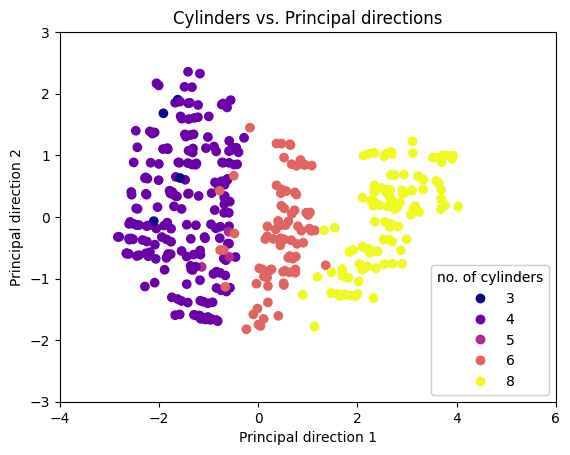

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-4, 6), ylim=(-3, 3))
scatter = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['cylinders'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="no. of cylinders")
ax1.add_artist(legend1)
plt.title('Cylinders vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

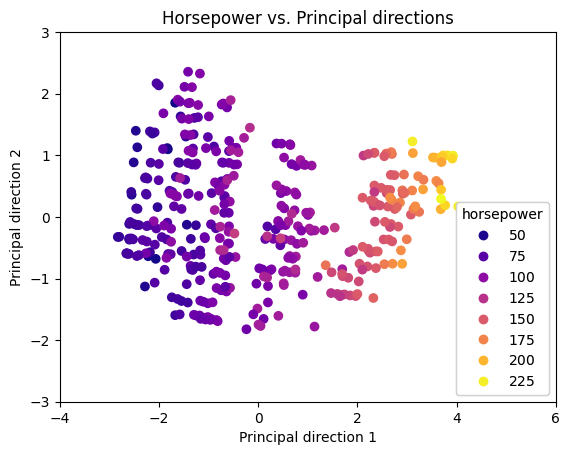

In [34]:
fig, ax1 = plt.subplots()
ax1.set(xlim=(-4, 6), ylim=(-3, 3))
scatter = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['horsepower'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="horsepower")
ax1.add_artist(legend1)
plt.title('Horsepower vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

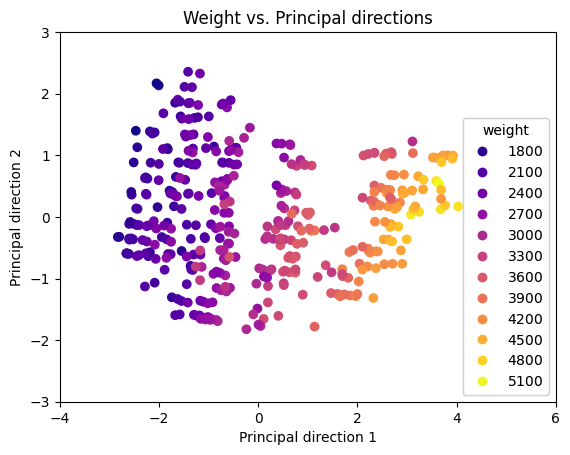

In [35]:
fig, ax1 = plt.subplots()
ax1.set(xlim=(-4, 6), ylim=(-3, 3))
scatter = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['weight'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="weight")
ax1.add_artist(legend1)
plt.title('Weight vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

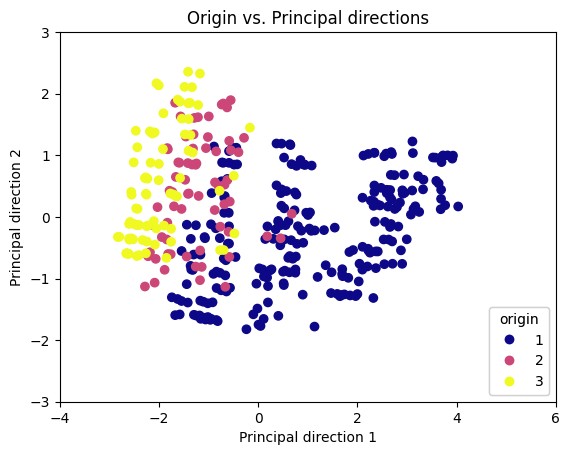

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-4, 6), ylim=(-3, 3))
scatter = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['origin'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="origin")
ax1.add_artist(legend1)
plt.title('Origin vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

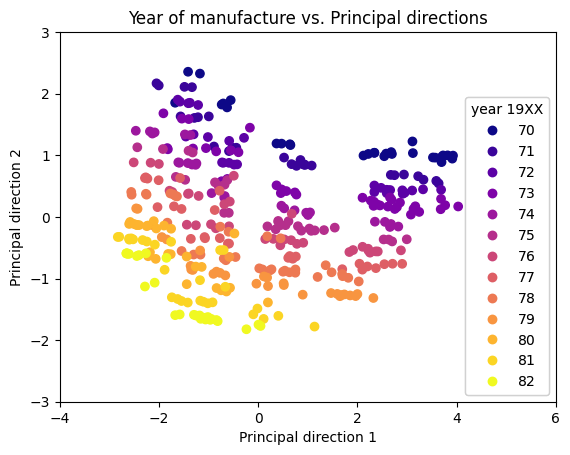

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set(xlim=(-4, 6), ylim=(-3, 3))
scatter = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['year'], cmap='plasma')
legend1 = ax1.legend(*scatter.legend_elements(), loc="lower right", title="year 19XX")
ax1.add_artist(legend1)
plt.title('Year of manufacture vs. Principal directions')
plt.xlabel('Principal direction 1')
plt.ylabel('Principal direction 2')
plt.show()

In [38]:
# Create a grid over the 2D plot axes domain
grid1 = np.linspace(-4,6,num=100)
grid2 = np.linspace(-3,3,num=100)
grid_list = []
for x in grid1:
    for y in grid2:
        grid_list.append([x, y])
        
grid = pd.DataFrame(grid_list, columns=['pc1', 'pc2'])

In [39]:
# Re-specify model architectures

# best parameters
#best_shrinkage = 0
#best_l1_ratio = 1
#best_k = 1
#best_depth_cart = 5
#best_n_trees = 5
#best_depth_rf = 6
#best_n_estimators = 200
#best_learn_rate = 0.35

lda_0 = LinearDiscriminantAnalysis(solver='eigen', shrinkage=best_shrinkage)
logit_0 = LogisticRegression(penalty='elasticnet', solver='saga',
                                 max_iter=500, l1_ratio=best_l1_ratio)
knn_0 = KNeighborsClassifier(n_neighbors=best_k)
cart_0 = tree.DecisionTreeClassifier(max_depth=best_depth_cart)
rforest_0 = RandomForestClassifier(n_estimators=best_n_trees, max_depth=best_depth_rf, random_state=0)
adaboost_0 = AdaBoostClassifier(n_estimators=best_n_estimators, learning_rate = best_learn_rate, random_state=0)

# Calculate/predict grid 'mpg01' labels for various models re-trained on PC2 data
grid['lda'] = lda_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['logit'] = logit_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['knn'] = knn_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['cart'] = cart_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['rforest'] = rforest_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])
grid['adaboost'] = adaboost_0.fit(pc2_X_train, y_train).predict(grid.iloc[:,:2])

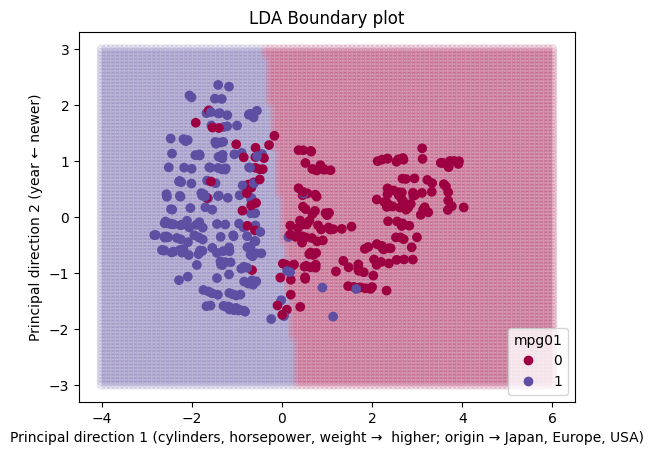

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['lda'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('LDA Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, horsepower, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()

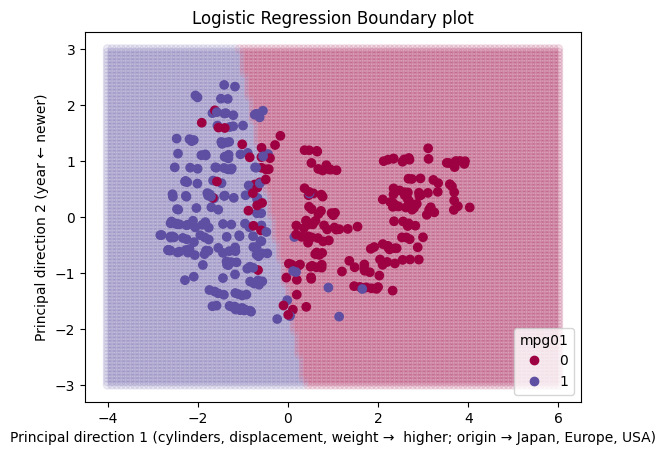

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['logit'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('Logistic Regression Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, displacement, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()

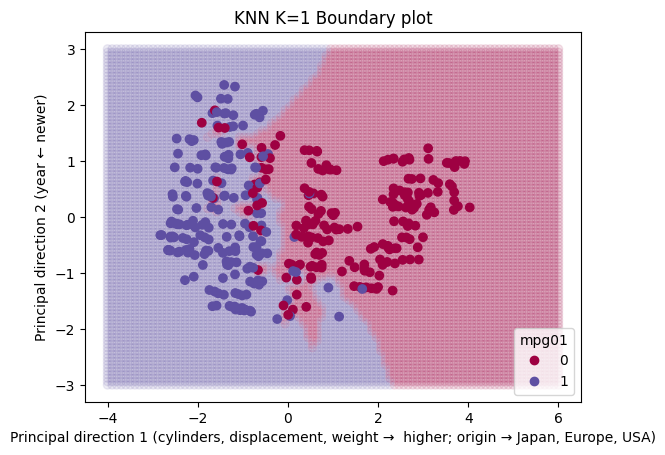

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['knn'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('KNN K=1 Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, displacement, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()

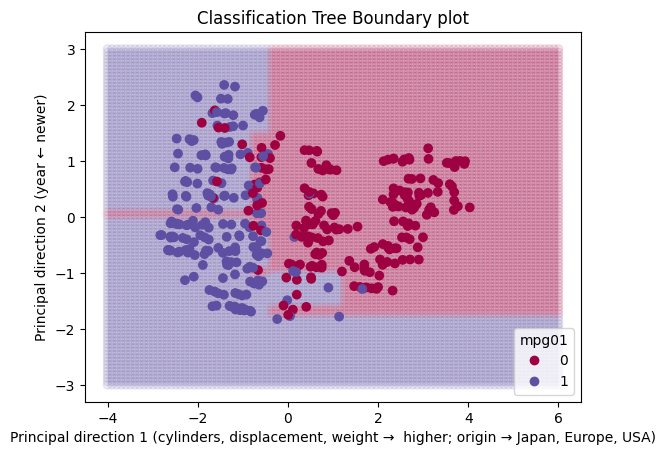

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['cart'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('Classification Tree Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, displacement, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()

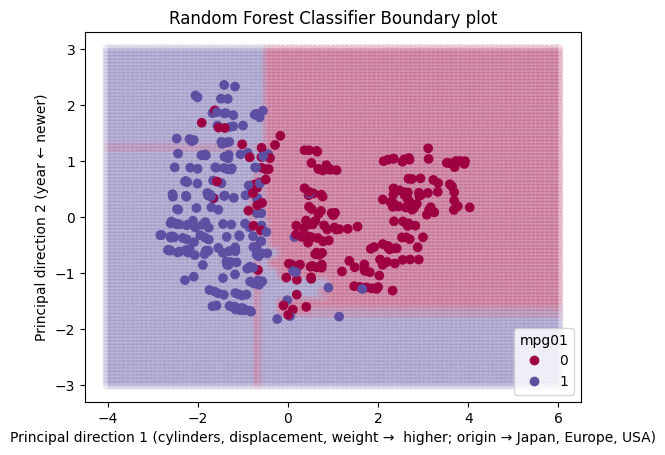

In [44]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['rforest'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('Random Forest Classifier Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, displacement, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()

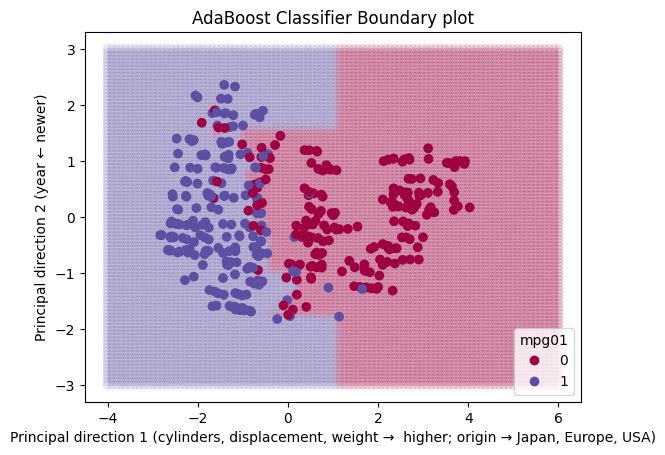

In [45]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
scatter1 = ax1.scatter(grid['pc1'], grid['pc2'], c=grid['adaboost'], cmap='Spectral', alpha=0.1)
scatter2 = ax1.scatter(pc12_auto_data['pc1'], pc12_auto_data['pc2'], c=pc12_auto_data['mpg01'], cmap='Spectral')
legend2 = ax1.legend(*scatter2.legend_elements(), loc="lower right", title="mpg01")
plt.title('AdaBoost Classifier Boundary plot')
plt.xlabel('Principal direction 1 (cylinders, displacement, weight →  higher; origin → Japan, Europe, USA)')
plt.ylabel('Principal direction 2 (year ← newer)')
plt.show()